In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict

In [2]:
"""
Import data
"""
raw_data = pd.read_pickle("data.pkl")
raw_data[0:5]

,subject,exp,phasename,num_rep,num_trial,num_formed,num_uttered,prompt,in_or_out,date_run,time_run,block,pitches
0,20,PU,5,44,1,2637,70,HECK,O,20170127,11,3,0 134.355450 1 134.360625 2 134...
1,20,PU,5,36,1,2629,62,HECK,O,20170127,11,3,0 130.217779 1 130.179978 2 130...
2,20,PU,7,20,1,2713,146,HECK,I,20170127,11,3,0 132.486939 1 132.479573 2 132...
3,20,PU,6,6,1,2649,82,HECK,O,20170127,11,3,0 139.037150 1 139.055242 2 139...
4,20,PU,7,8,1,2701,134,HECK,I,20170127,11,3,0 130.927041 1 130.913059 2 130...


In [4]:
"""
Generate summary statistics for each trial
"""

agg: Dict[int, float] = {
    "count": [],
    "avg": [],
    "std": [],
    "minimum": [],
    "med": [],
    "maximum": [],
}

for pitches in raw_data.pitches:
    (
        count,
        avg,
        std,
        minimum,
        _,
        med,
        _,
        maximum,
                ) = pitches.describe()
    agg["count"].append(count)
    agg["avg"].append(avg)
    agg["std"].append(std)
    agg["minimum"].append(minimum)
    agg["med"].append(med)
    agg["maximum"].append(maximum)
    
# Preview summary statistics
summary_stats = pd.DataFrame(agg)
summary_stats[0:5]

,count,avg,std,minimum,med,maximum
0,491.0,133.610873,1.544445,124.930762,133.915850,134.887327
1,531.0,128.870786,1.549235,124.541467,129.371750,132.296456
2,461.0,129.790462,2.313823,126.706926,129.097929,135.363120
3,461.0,137.901782,0.786993,135.052405,137.730314,140.124944
4,441.0,125.673118,2.379921,121.275458,125.697445,131.048169


In [17]:
"""
Preprocessing
"""

subjects = raw_data.subject.unique()

# Subset only start phase trials with the prompt "HECK"
trial_f0 = summary_stats.avg[(raw_data.phasename == 4) & (raw_data.prompt == "HECK")]
trial_subject = raw_data.subject[(raw_data.phasename == 4) & (raw_data.prompt == "HECK")] 

# Get the baseline F0 for each subject
f0s = {}
for subject in subjects:
    trials = trial_f0[subject == trial_subject]
    subject_f0 = trials.mean()
    f0s[subject] = subject_f0

# Subtract pitches from baseline F0 
corrected_pitches = []

# For each trial
for i in range(len(raw_data)):
    
    # Get the pitches 
    trial_pitches = raw_data.pitches[i]
    
    # Get the subject's f0
    subject = raw_data.subject[i]
    f0 = f0s[subject]
    
    # Subtract f0 from values
    trial_corrected_pitches = trial_pitches - f0
    
    # Take mean
    trial_corrected_pitches = trial_corrected_pitches.mean()
    
    # Save in new arrage
    corrected_pitches.append(trial_corrected_pitches)
    
# Create new data frame
cleaned_data = raw_data.drop(columns = ['pitches', 'num_trial'])
cleaned_data['corrected_pitches'] = corrected_pitches

# Remove "O" data
cleaned_data = cleaned_data[cleaned_data.in_or_out == "O"]

# Remove first block
cleaned_data = cleaned_data[cleaned_data.block != 1]

# Preview
cleaned_data[0:5]

,subject,exp,phasename,num_rep,num_formed,num_uttered,prompt,in_or_out,date_run,time_run,block,corrected_pitches
0,20,PU,5,44,2637,70,HECK,O,20170127,11,3,12.959268
1,20,PU,5,36,2629,62,HECK,O,20170127,11,3,8.219181
3,20,PU,6,6,2649,82,HECK,O,20170127,11,3,17.250177
5,20,PU,1,1,2568,1,HECK,O,20170127,11,3,-5.116316
7,20,PU,5,39,2632,65,HECK,O,20170127,11,3,13.723759


Text(0, 0.5, 'Change in F0')

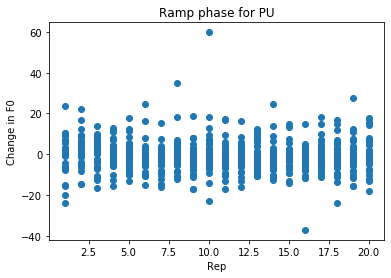

In [53]:
sub = sub.sort_values(by = ['block', 'phasename', 'num_rep'])

## PU ##
sub = cleaned_data[cleaned_data.exp == "PU"]
condition = sub.exp.unique()[0]

## Phase 4 ##
sub = sub[sub.phasename == 4]

# Plot
x = sub.num_rep
y = sub.corrected_pitches
plt.scatter(x, y)
plt.title("Ramp phase for " + condition)
plt.xlabel("Rep")
plt.ylabel("Change in F0")

In [37]:
print(condition[0])

PU


In [34]:
type(condition)

numpy.ndarray

In [30]:
cleaned_data.num_trial.unique()

array([1])